## This EDA is a trade-off between augmented and original data

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

!pip install chart_studio
!pip install textstat
!pip install umap-learn
!pip install -U sentence-transformers

import numpy as np
import pandas as pd 
import os
from collections import Counter
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import chart_studio.plotly as py
from plotly.offline import iplot
import cufflinks
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')
import umap
from sentence_transformers import SentenceTransformer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from collections import defaultdict
from collections import Counter
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import re
from nltk.tokenize import word_tokenize
import gensim
import string

     |████████████████████████████████| 64 kB 156 kB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
     |████████████████████████████████| 102 kB 188 kB/s 
     |████████████████████████████████| 3.0 MB 2.2 MB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
     |████████████████████████████████| 66 kB 165 kB/s 
     |████████████████████████████████| 1.1 MB 543 kB/s 
     |████████████████████████████████| 3.0 MB 1.5 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.3.8-py3-none-any.whl size=101994 sha256=9305d2701ee295f187f644326583d700e3c294ffb2f193777adf8de61a814fd7
  Stored in directory: /root/.cache/pip/wheels/1c/43/65/fe0f3ea9327623e749a79eb5dfad85a809c84064b1cc4682c1
Successfully built sentence-transformers
  Attempting uninstall

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [2]:
""" This EDA is a trade-off between augmented and original data
"""
df1 = pd.read_csv('../input/bmw-intent-training/bmw_training_set.csv')
df2 = pd.read_csv('../input/data-set-augment-intent/data_file.csv')

' This EDA is a trade-off between augmented and original data\n'

### Class Augment distributuion with respect to the original class

In [3]:
v = pd.DataFrame()
v['count_bef'] = df1['Intent'].value_counts().values
v['class'] = df1['Intent'].value_counts().index
v = v.sort_values(by='class')
g = pd.DataFrame()
g['count_aft'] = df2['Intent'].value_counts().values
g['class'] = df2['Intent'].value_counts().index
g = g.sort_values(by='class')
g['count_bef'] = v['count_bef'].values
g['diff'] = g['count_aft'] - g['count_bef']
g['percent_change'] = g['diff']*100 / g['count_bef']

g.style.background_gradient(cmap='Blues',subset=["count_bef"])\
                        .background_gradient(cmap='Reds',subset=["count_aft"])\
                        .background_gradient(cmap='Greens',subset=["diff"])\
                        .background_gradient(cmap='Purples',subset=["percent_change"])

In [4]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
df1['Utterance_without_stopwords'] = df1['Utterance'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df1['temp_list'] = df1['Utterance_without_stopwords'].apply(lambda x:x.lower().split(" "))
top = Counter([item for sublist in df1['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(50))
temp.columns = ['Common_words','count']
fig = px.treemap(temp, path=['Common_words'], values='count',title='Common Words in dataset without augment')
fig.show()

In [5]:

df2['Utterance_without_stopwords'] = df2['Utterance'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df2['temp_list'] = df2['Utterance_without_stopwords'].apply(lambda x:x.lower().split(" "))
top = Counter([item for sublist in df2['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(50))
temp.columns = ['Common_words','count']
fig = px.treemap(temp, path=['Common_words'], values='count',title='Common Words with augmentation')
fig.show()

In [6]:
df1['text_len'] = df1['Utterance'].apply(lambda x:len(x))
df2['text_len'] = df2['Utterance'].apply(lambda x:len(x))

df1['text_len'].iplot(
    kind='hist',
    bins=100,
    xTitle='text length',
    linecolor='black',
    color='red',
    yTitle='count',
    title='Data Length Distribution')

df2['text_len'].iplot(
    kind='hist',
    bins=120,
    xTitle='text length',
    linecolor='black',
    color='green',
    yTitle='count',
    title='Augmented Data Text Length Distribution')

### Though the augmeted data distribution is a little bit skewed but still they are a bit same

In [7]:
df1['word_text_len'] = df1['Utterance'].apply(lambda x:len(x.split(' ')))
df2['word_text_len'] = df2['Utterance'].apply(lambda x:len(x.split(' ')))

df1['word_text_len'].iplot(
    kind='hist',
    bins=100,
    xTitle='text length',
    linecolor='black',
    color='red',
    yTitle='count',
    title='Data Length Distribution')

df2['word_text_len'].iplot(
    kind='hist',
    bins=100,
    xTitle='text length',
    linecolor='black',
    color='green',
    yTitle='count',
    title='Augmented Data Text Length Distribution')

### Same goes with text-lenght 

In [8]:
def get_top_n_gram(corpus,ngram_range,n=None):
    vec = CountVectorizer(ngram_range=ngram_range,stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

before_bigrams = get_top_n_gram(df1['Utterance'],(2,2),20)
after_bigrams = get_top_n_gram(df2['Utterance'],(2,2),20)


out_before = pd.DataFrame(before_bigrams, columns = ['Text' , 'count'])
out_before.groupby('Text').sum()['count'].sort_values(ascending=True).iplot(
    kind='bar', yTitle='Count', linecolor='black',color='red', title='Top 20 Bigrams in Original Data',orientation='h')

out_after = pd.DataFrame(after_bigrams, columns = ['Text' , 'count'])
out_after.groupby('Text').sum()['count'].sort_values(ascending=True).iplot(
    kind='bar', yTitle='Count', linecolor='black', color='green',title='Top 20 Bigrams in Augmented Data',orientation='h')

In [9]:
before_bigrams = get_top_n_gram(df1['Utterance'],(3,3),20)
after_bigrams = get_top_n_gram(df2['Utterance'],(3,3),20)

out_before = pd.DataFrame(before_bigrams, columns = ['Text' , 'count'])
out_before.groupby('Text').sum()['count'].sort_values(ascending=True).iplot(
    kind='bar', yTitle='Count', linecolor='black',color='red', title='Top 20 Trigrams in Original Data',orientation='h')

out_after = pd.DataFrame(after_bigrams, columns = ['Text' , 'count'])
out_after.groupby('Text').sum()['count'].sort_values(ascending=True).iplot(
    kind='bar', yTitle='Count', linecolor='black', color='green',title='Top 20 Trigrams in Augmented Data',orientation='h')

In [10]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
labels_before = le.fit_transform(df1['Intent'].values)
labels_after = le.fit_transform(df2['Intent'].values)

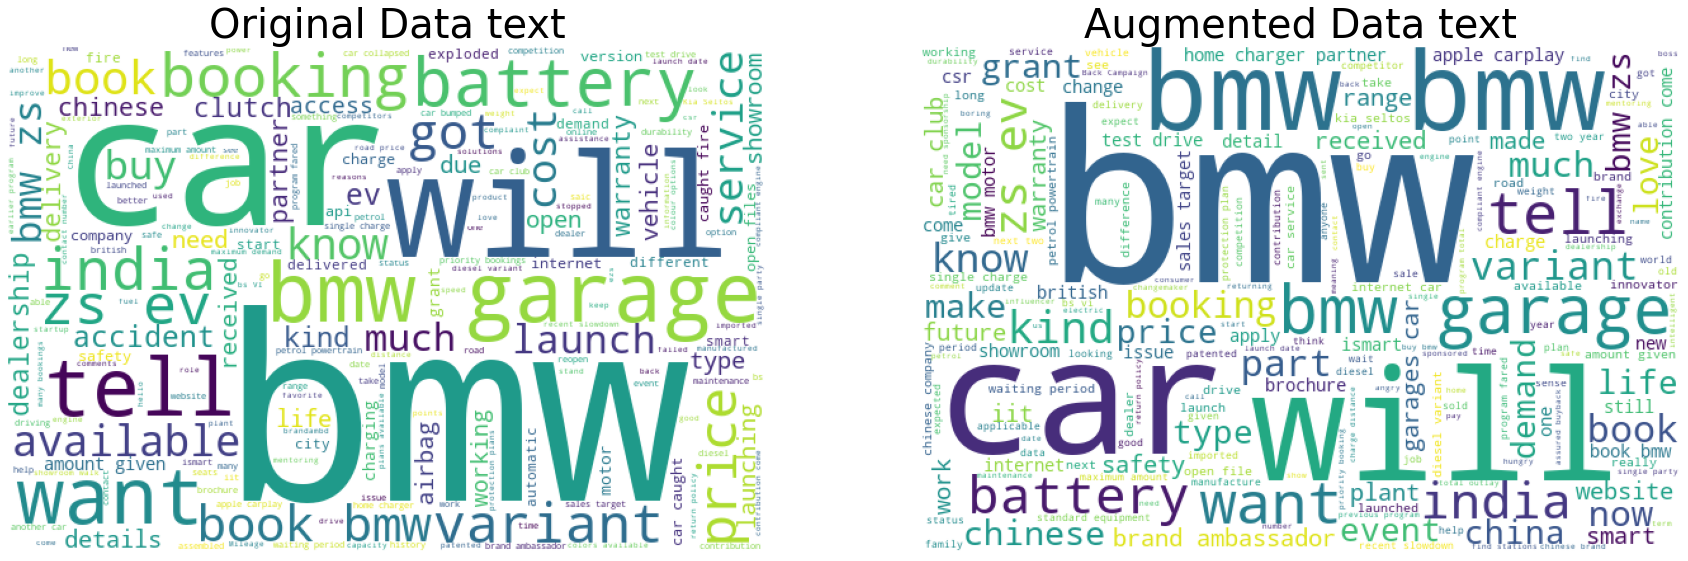

In [11]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[30, 15])
wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(df1['Utterance'].values))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Original Data text',fontsize=40);

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(df2['Utterance'].values))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Augmented Data text',fontsize=40);

### This the way i converted the text to embeddings with sentence transformers same is done in LGBM modeling

In [12]:
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings_before = model.encode(df1['Utterance'].values, show_progress_bar=True)
embeddings_after = model.encode(df2['Utterance'].values, show_progress_bar=True)

100%|██████████| 245M/245M [00:32<00:00, 7.49MB/s]


### UMAP embeddings of both Original and Augmented Dataset

In [13]:
%%time
umap_embeddings_before = umap.UMAP(n_neighbors=15,
                            n_components=10,
                            min_dist=0.0,
                            metric='cosine',
                            random_state=42).fit_transform(embeddings_before)


umap_embeddings_after = umap.UMAP(n_neighbors=15,
                            n_components=10,
                            min_dist=0.0,
                            metric='cosine',
                            random_state=42).fit_transform(embeddings_after)

CPU times: user 1min 2s, sys: 253 ms, total: 1min 2s
Wall time: 1min 1s


### Showing them in 3D
#### 1.with original data points 
#### 2.with Augmented data points
##### sorry for the whitish points they are still the same points plz zoom on them

In [14]:
umap_data = umap.UMAP(n_neighbors=10, n_components=3, min_dist=0.0, metric='cosine').fit_transform(embeddings_before)
result = pd.DataFrame(umap_data, columns=['x', 'y','z'])
result['labels'] = labels_before
result['size'] = 50
fig = px.scatter_3d(result, x="x", y="y",z='z', color="labels",size='size',hover_data=['labels'])
fig.show()

In [15]:
umap_data = umap.UMAP(n_neighbors=30, n_components=3, min_dist=0.0, metric='cosine').fit_transform(embeddings_after)
result = pd.DataFrame(umap_data, columns=['x', 'y','z'])
result['labels'] = labels_after
result['size'] = 50
fig = px.scatter_3d(result, x="x", y="y",z='z', color="labels",size='size',hover_data=['labels'])
fig.show()